In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
import scipy.io as sio 
import numpy as np
import math
import time
tf.compat.v1.reset_default_graph()

In [2]:
envir = 'outdoor' #'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels
# network params
residual_num = 2
encoded_dim = 512 #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
file = (envir)+'_dim'+str(encoded_dim)

In [3]:
# Data loading
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_Htestin.mat')
    x_test = mat['HT'] # array

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_Htestout.mat')
    x_test = mat['HT'] # array

x_test = x_test.astype('float32')
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [4]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='optimized_models/%s/xnnpack_model_%s.tflite'%(file, file))
interpreter.resize_tensor_input(0, [len(x_test), img_channels, img_height, img_width])
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]


# Test the model input data.
interpreter.set_tensor(input_details['index'], x_test)

tStart = time.time()
interpreter.invoke()
tEnd = time.time()

# # The function `get_tensor()` returns a copy of the tensor data.
# # Use `tensor()` in order to get a pointer to the tensor.

x_hat = interpreter.get_tensor(output_details['index'])
print ("It cost %f sec" % (tEnd-tStart))

It cost 24.119198 sec


In [8]:
# Calcaulating the NMSE and rho
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_HtestFin_all.mat')
    X_test = mat['HF_all']# array

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_HtestFout_all.mat')
    X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = n1.astype('float64')
n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = n2.astype('float64')
aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

C:\Users\Omar\AppData\Local\Temp\ipykernel_11980\1351432001.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  n1 = n1.astype('float64')
C:\Users\Omar\AppData\Local\Temp\ipykernel_11980\1351432001.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  n2 = n2.astype('float64')


In indoor environment
When dimension is 32
NMSE is  -5.731045622805645
Correlation is  0.8694844529345508


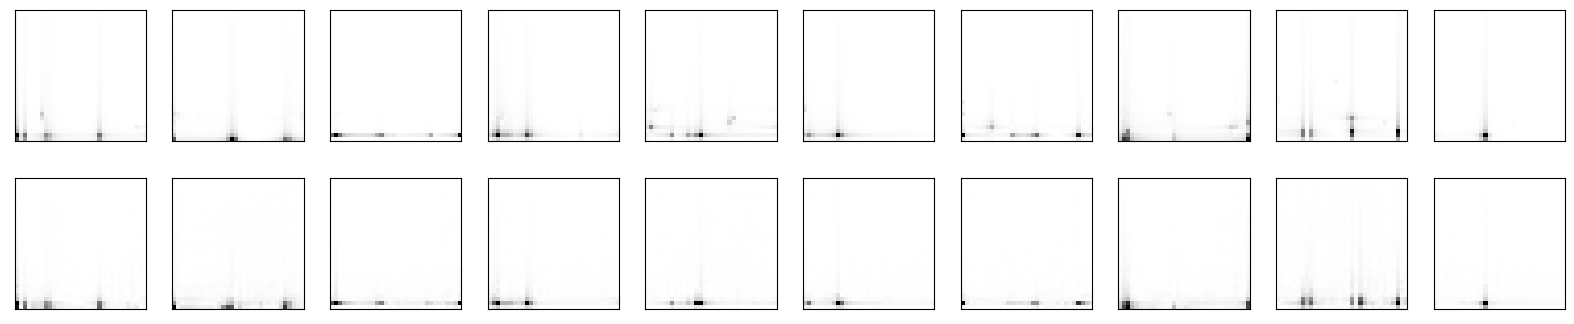

In [6]:
import matplotlib.pyplot as plt
'''abs'''
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display origoutal
    ax = plt.subplot(2, n, i + 1 )
    x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5 
                          + 1j*(x_hat[i, 1, :, :]-0.5))
    plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
plt.show()